In [101]:
!pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [131]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from skimage.feature import greycomatrix, greycoprops
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [103]:
# Mendefinisikan path folder dataset
dataset_path = "/content/drive/MyDrive/TA05/dataset"

In [104]:
# Mendefinisikan list nama folder dataset
folder_names = ["blackspot", "canker", "fresh", "grenning"]

# Penjelasan Ukuran Gambar
Pemilihan image_size yang tepat tergantung pada jenis dataset yang digunakan dan kompleksitas masalah klasifikasi. 
Jika dataset yang digunakan memiliki banyak variasi dalam hal ukuran gambar, 
maka lebih disarankan untuk menggunakan image_size yang lebih besar, seperti (256, 256), 
agar gambar dapat diresize dengan ukuran yang serupa sehingga tidak mempengaruhi ekstraksi fitur. 
Namun, jika dataset yang digunakan memiliki ukuran gambar yang seragam dan tidak terlalu besar, 
maka image_size yang lebih kecil, seperti (64, 64), mungkin sudah cukup untuk mempercepat proses 
ekstraksi fitur dan pelatihan model. Selain itu, ukuran image_size juga dapat mempengaruhi kinerja model, 
misalnya model yang dilatih dengan gambar ukuran kecil mungkin tidak dapat mengenali detail gambar yang halus. Oleh karena itu, pemilihan image_size yang tepat harus mempertimbangkan beberapa faktor, seperti karakteristik dataset, kompleksitas masalah klasifikasi, dan kinerja model.

In [107]:
# Mendefinisikan ukuran gambar yang digunakan
image_size = (64, 64) # bisa 64, 256, dll

# Penjelasan Mendefinisikan metode GLCM
glcm_distances adalah parameter pada fungsi 
greycomatrix() -> Lihat dibagian "Looping untuk membaca dataset dan mengekstraksi fitur"
yang menentukan jarak atau distance antara dua piksel yang digunakan 
untuk menghitung matrix glcm (grey-level co-occurrence matrix). 
Matrix glcm merepresentasikan jumlah kemunculan pasangan nilai 
intensitas piksel yang muncul secara bersamaan pada suatu jarak dan 
arah tertentu pada gambar.
Pada kode program yang disebutkan di atas, glcm_distances diatur sebagai [1], 
yang artinya matrix glcm hanya akan dihitung untuk jarak 1 piksel saja. 
Dalam hal ini, hanya pasangan piksel dengan jarak 1 piksel yang akan dihitung 
kemunculannya dalam matrix glcm. Hal ini menunjukkan bahwa hanya pola kemunculan 
pasangan piksel pada jarak yang relatif dekat yang akan diperhitungkan dalam ekstraksi fitur. 
Pengaturan jarak yang lebih besar dari 1, misalnya [1, 2, 3], akan memperhitungkan kemunculan 
pasangan piksel pada jarak yang lebih jauh, yang mungkin dapat menghasilkan informasi tambahan 
tentang tekstur gambar. Namun, pengaturan jarak yang lebih besar juga dapat memperbesar ukuran 
matrix glcm dan memperlambat ekstraksi fitur. Oleh karena itu, pemilihan nilai glcm_distances 
yang tepat harus mempertimbangkan keseimbangan antara kinerja dan akurasi model.




glcm_angles adalah parameter pada fungsi 
greycomatrix() -> Lihat dibagian "Looping untuk membaca dataset dan mengekstraksi fitur"
yang menentukan sudut atau arah antara dua piksel 
yang digunakan untuk menghitung matrix GLCM (Grey-Level Co-occurrence Matrix). 
Matrix GLCM merepresentasikan jumlah kemunculan pasangan nilai intensitas piksel yang muncul 
secara bersamaan pada suatu jarak dan arah tertentu pada gambar.
Pada kode program yang disebutkan di atas, glcm_angles diatur sebagai 
[0, np.pi/4, np.pi/2, 3*np.pi/4], yang artinya matrix GLCM akan dihitung 
untuk empat arah atau sudut yang berbeda, yaitu 0 derajat (ke kanan), 
45 derajat (ke kanan bawah), 90 derajat (ke bawah), dan 135 derajat (ke kiri bawah). 
Dalam hal ini, ekstraksi fitur GLCM dilakukan dengan mempertimbangkan kemunculan 
pasangan piksel pada empat arah tersebut. Pengaturan sudut yang berbeda dapat 
memberikan informasi tambahan tentang tekstur gambar yang dapat membantu meningkatkan 
akurasi model. Namun, pengaturan sudut yang lebih banyak juga dapat memperbesar 
ukuran matrix GLCM dan memperlambat ekstraksi fitur. Oleh karena itu, pemilihan 
nilai glcm_angles yang tepat harus mempertimbangkan keseimbangan antara kinerja dan akurasi model




glcm_properties adalah parameter pada fungsi 
greycoprops() -> Lihat dibagian "Looping untuk membaca dataset dan mengekstraksi fitur juga"
yang menentukan jenis fitur GLCM (Grey-Level Co-occurrence Matrix) 
yang akan diekstraksi dari matrix GLCM. 
GLCM adalah matrix yang merepresentasikan jumlah kemunculan 
pasangan nilai intensitas piksel yang muncul secara bersamaan 
pada suatu jarak dan arah tertentu pada gambar. Ekstraksi fitur GLCM 
dilakukan dengan menghitung nilai rata-rata dari jenis fitur GLCM yang diinginkan, 
misalnya kontras, homogenitas, energi, dan korelasi, dari matrix GLCM tersebut.
Pada kode program yang disebutkan di atas, glcm_properties diatur sebagai 
['contrast', 'homogeneity', 'energy', 'correlation'], 
yang artinya akan diekstraksi lima jenis fitur GLCM, yaitu kontras, homogenitas, energi, dan korelasi. 
Pengaturan jenis fitur yang berbeda dapat memberikan informasi tambahan 
tentang tekstur gambar yang dapat membantu meningkatkan akurasi model. 
Namun, pengaturan jenis fitur yang lebih banyak juga dapat memperbesar 
ukuran fitur dan memperlambat ekstraksi fitur. Oleh karena itu, 
pemilihan jenis fitur glcm_properties yang tepat harus mempertimbangkan 
keseimbangan antara kinerja dan akurasi model.

In [108]:
# Mendefinisikan metode GLCM
glcm_distances = [1]
glcm_angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
glcm_properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']

# Penjelasan Mendefinisikan metode HSV
Pada kode program yang disebutkan di atas, hsv_properties diatur sebagai ['hue', 'saturation', 'value'], yang artinya akan diekstraksi ketiga jenis fitur HSV tersebut. Pengaturan jenis fitur yang berbeda dapat memberikan informasi tambahan tentang warna dan kecerahan gambar yang dapat membantu meningkatkan akurasi model. Namun, pengaturan jenis fitur yang lebih banyak juga dapat memperbesar ukuran fitur dan memperlambat ekstraksi fitur. Oleh karena itu, pemilihan jenis fitur hsv_properties yang tepat harus mempertimbangkan keseimbangan antara kinerja dan akurasi model.

In [109]:
# Mendefinisikan metode HSV
hsv_properties = ['hue', 'saturation', 'value']

# Penjelasan Ekstraksi Fitur
Program di atas merupakan implementasi dari proses ekstraksi fitur pada dataset. Proses ini dilakukan untuk mengubah setiap citra pada dataset menjadi representasi fitur numerik yang dapat digunakan untuk melatih model klasifikasi.

Secara rinci, fungsi program di atas adalah sebagai berikut:

Inisialisasi list fitur dan label dengan membuat dua list kosong bernama features dan labels.

Looping untuk membaca dataset dan mengekstraksi fitur dari setiap citra pada dataset.

  a. Pertama, dilakukan inisialisasi dua buah dictionary bernama hsv_values dan glcm_values yang akan digunakan untuk menyimpan nilai HSV dan GLCM dari setiap citra pada dataset.

  b. Selanjutnya, dilakukan looping untuk membaca setiap citra pada dataset. Citra ini dibaca dari lokasi direktori file dan kemudian di-resize ke ukuran yang ditentukan. Setelah itu, citra tersebut diubah menjadi citra dalam mode HSV dan citra dalam mode grayscale untuk dilakukan ekstraksi fitur.

  c. Setelah mendapatkan citra dalam mode HSV, nilai HSV dari setiap piksel pada citra tersebut diekstraksi dan disimpan pada dictionary hsv_values.

  d. Selanjutnya, dilakukan ekstraksi fitur GLCM dari citra grayscale menggunakan GLCM (Grey Level Co-occurence Matrix) dengan jarak, sudut, dan properti GLCM yang ditentukan. Nilai GLCM yang dihasilkan disimpan pada dictionary glcm_values.

  e. Kemudian, dilakukan ekstraksi fitur dari citra dalam mode HSV dan citra dalam mode grayscale. Untuk setiap citra, dilakukan ekstraksi fitur HSV dan GLCM, dan hasil ekstraksi fitur ini disimpan pada list features.

  f. Selain itu, label dari setiap citra ditambahkan pada list labels dengan menggunakan index dari folder citra tersebut pada list folder_names.

Setelah selesai looping pada dataset, hasil ekstraksi fitur dari setiap citra dan label dari setiap citra disimpan dalam list features dan labels, yang kemudian digunakan untuk melatih model klasifikasi.

Dengan melakukan ekstraksi fitur seperti pada program di atas, kita dapat mengubah setiap citra pada dataset menjadi representasi fitur numerik yang dapat digunakan untuk melatih model klasifikasi. Selain itu, ekstraksi fitur dapat meningkatkan performa model klasifikasi dengan mengurangi dimensi fitur dan menyingkirkan fitur yang tidak relevan atau redundan.

In [110]:
# Inisialisasi list fitur dan label
features = []
labels = []
# Looping untuk membaca dataset dan mengekstraksi fitur
hsv_values = {}
glcm_values = {}
for folder_name in folder_names:
    folder_path = os.path.join(dataset_path, folder_name)
    for file_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, file_name)
        image = cv2.imread(image_path)
        image = cv2.resize(image, image_size)
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hsv_values[file_name] = [hsv_image[:,:,0].tolist(), hsv_image[:,:,1].tolist(), hsv_image[:,:,2].tolist()]
        glcm_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        glcm = greycomatrix(glcm_image, distances=glcm_distances, angles=glcm_angles, symmetric=True, normed=True)
        glcm_values[file_name] = [greycoprops(glcm, property_name).tolist() for property_name in glcm_properties]
        hsv_features = []
        for property_name in hsv_properties:
            property_value = hsv_image[:,:,hsv_properties.index(property_name)].ravel()
            hsv_features.extend([np.mean(property_value), np.std(property_value)])
        glcm_features = []
        for property_name in glcm_properties:
            property_value = greycoprops(glcm, property_name).ravel()
            glcm_features.extend([np.mean(property_value), np.std(property_value)])
        features.append(hsv_features+glcm_features)
        labels.append(folder_names.index(folder_name))

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.9/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.9/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.9/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.9/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')

In [111]:
# Menampilkan nilai HSV dan GLCM dari gambar
for file_name, hsv_value in hsv_values.items():
    print("Values of", file_name)
    print("HSV values:", hsv_value[0], hsv_value[1], hsv_value[2])
    print("GLCM values:")
    for property_name, property_value in zip(glcm_properties, glcm_values[file_name]):
        print(property_name, ":", property_value)
    print()

Output hidden; open in https://colab.research.google.com to view.

In [112]:
# Total keseluruhan dataset
print(len(hsv_values))

1180


In [113]:
# Split data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2,random_state=42)

# Penjelasan KNeighborsClassifier
Pada inisialisasi model, jumlah neighbor yang digunakan pada KNeighborsClassifier diatur menjadi 5 dengan parameter n_neighbors=5. Hal ini menunjukkan bahwa model akan mencari 5 tetangga terdekat dari data uji terdekat untuk melakukan klasifikasi. Jumlah neighbor yang dipilih dapat mempengaruhi kinerja model. Dalam beberapa kasus, nilai n_neighbors yang terlalu kecil dapat menyebabkan model overfitting, sedangkan nilai yang terlalu besar dapat menyebabkan model underfitting. Oleh karena itu, nilai n_neighbors yang optimal harus dipilih dengan hati-hati melalui validasi silang atau eksperimen.

In [114]:
# Inisialisasi model KNN
knn = KNeighborsClassifier(n_neighbors=5)
# Train model KNN
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [126]:
# Install dan import library untuk menghubungkan Google Drive
!pip install google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [127]:
# Menyimpan model KNN
!pip install joblib
import joblib
joblib.dump(knn, '/content/drive/MyDrive/TA05/model/knn_model.pkl')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


['/content/drive/MyDrive/TA05/model/knn_model.pkl']

In [128]:
# Prediksi label dari data test
y_pred = knn.predict(X_test)

In [129]:
# Menghitung akurasi model
accuracy = accuracy_score(y_test, y_pred)

In [130]:
print("Akurasi model:", accuracy)

Akurasi model: 0.885593220338983


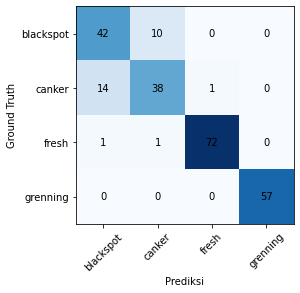

In [135]:
# Mencetak confusion matrix dalam bentuk plot
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)

# Menambahkan label pada sumbu x dan y
plt.xticks(np.arange(len(folder_names)), folder_names, rotation=45)
plt.yticks(np.arange(len(folder_names)), folder_names)
plt.xlabel("Prediksi")
plt.ylabel("Ground Truth")

# Menambahkan nilai pada kotak confusion matrix
for i in range(len(folder_names)):
    for j in range(len(folder_names)):
        plt.text(j, i, str(cm[i][j]), ha="center", va="center")

plt.show()